## Movielens

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

In [2]:
torch.cuda.set_device(2)

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [4]:
path='data/ml-latest-small/'

We're working with the movielens data, which contains one rating per row, like this:

In [5]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Just for display purposes, let's read in the movie names too.

In [6]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [7]:
type(ratings)

pandas.core.frame.DataFrame

In [8]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


## Collaborative filtering

In [9]:
val_idxs = get_cv_idxs(len(ratings))
# weight decay, it's L2 regularization basically
wd=2e-4
# how big the embedding matrix we want for user and movie
n_factors = 50

In [11]:
??CollabFilterDataset.from_csv

In [12]:
# userId->row, movieId->column, rating->value
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
# 64->batch size
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [14]:
cf

In [15]:
learn

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

In [17]:
type(learn)

fastai.column_data.CollabFilterLearner

In [18]:
# No pre-trained model here, start from randomly initializing.
# This is the mean squared error, not a root mean squared error.
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.812714   0.809548  
    1      0.757037   0.77905                                                                                          
    2      0.614219   0.765143                                                                                         



[array([0.76514])]

Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [19]:
math.sqrt(0.766)

0.8752142594816426

Looking good - we've found a solution better than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [20]:
preds = learn.predict()

C:\Users\hasun\AppData\Local\Continuum\anaconda3\envs\fastai\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\hasun\AppData\Local\Continuum\anaconda3\envs\fastai\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


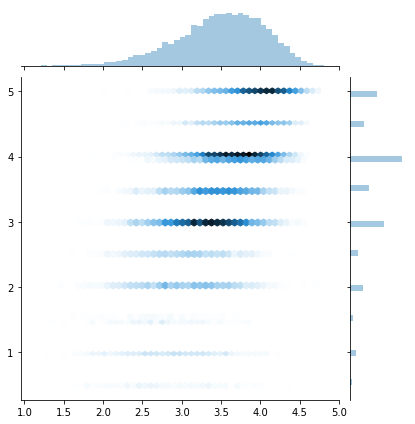

In [21]:
y=learn.data.val_y
# seaborn is a really great plotting library, it sits on top of matplotlib
sns.jointplot(preds, y, kind='hex', stat_func=None);

## Analyze results

### Movie bias

In [22]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [23]:
movie_names

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (a.k.a. 12 Monkeys) (199

In [24]:
topMovieIdx

array([  57,   49,   99, ...,  668, 4252, 4213])

In [29]:
# This is fastai type
??learn.models

In [28]:
??learn.model

In [30]:
# learn.model return the pytorch model file
m=learn.model; m.cuda()

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [31]:
# Pytorch model or layer (such as m.ib below) can be called by using (), remember a layer can also be a model. Then it requires
# variables as input not the tensors becuase it need to keep track of the derivatives, so we use V to transform the tensor to
# be variable. 
# Variable is kind of wrapper on the tensor.
# Pytorch 0.4 announced that it will get rid of the variables, and be able to use tensors to keep track of the derivatives
#
# to_np: m.ib(V(topMovieIdx)) is on GPU as below, we have a little shortcut in fastai because we very often want to turn variables
# into tensors and move back to the CPU so we can play with them more easily. to_np is to numpy and it does all of those
# things, and it works regardless of whether it is a tensor or a variable and regardless of whether it is on CPU or GPU, it
# will end up giving you a numpy array from that. This is a super handy thing when you play around with pytorch. I try to use
# numpy for everything except I explicitly need to run something on GPU or I need its derivatives in which cases I use pytorch,
# because I found numpy is easier to work with and it's been longer time than pytorch and lots of things like python image
# libraries like OpenCV, and lots of other stuffs like pandas
#
# if you want to use you model for infer in CPU not GPU, you can call m.cpu(), then uses m as usual. If the machine do not
# have GPU, you do not need to do so.
movie_bias = to_np(m.ib(V(topMovieIdx)))

In [32]:
m.ib(V(topMovieIdx))

Variable containing:
 0.8075
 0.8016
 1.3011
   ⋮    
 0.2708
-0.0586
 0.2269
[torch.cuda.FloatTensor of size 3000x1 (GPU 2)]

In [33]:
movie_bias

array([[ 0.80747],
       [ 0.80161],
       [ 1.30106],
       ...,
       [ 0.27079],
       [-0.05861],
       [ 0.22685]], dtype=float32)

In [34]:
# zip is very important in python: it iterates the things in it and make a tuple of each.
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [35]:
# Here we use the bias value to interpret good or bad of the movie
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.90008533, 'Battlefield Earth (2000)'),
 (-0.7443258, 'Batman & Robin (1997)'),
 (-0.74413127, 'Super Mario Bros. (1993)'),
 (-0.7438049, 'Speed 2: Cruise Control (1997)'),
 (-0.73753434, 'Wild Wild West (1999)'),
 (-0.6908002, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.6672073, 'Godzilla (1998)'),
 (-0.6480359, 'Inspector Gadget (1999)'),
 (-0.6215282, 'Superman III (1983)'),
 (-0.6094794, 'Congo (1995)'),
 (-0.60052055, 'Hollow Man (2000)'),
 (-0.59275645, 'Anaconda (1997)'),
 (-0.58827657, 'Haunting, The (1999)'),
 (-0.5853191, 'Flintstones, The (1994)'),
 (-0.58104974, 'Little Nicky (2000)')]

In [36]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.90008533, 'Battlefield Earth (2000)'),
 (-0.7443258, 'Batman & Robin (1997)'),
 (-0.74413127, 'Super Mario Bros. (1993)'),
 (-0.7438049, 'Speed 2: Cruise Control (1997)'),
 (-0.73753434, 'Wild Wild West (1999)'),
 (-0.6908002, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.6672073, 'Godzilla (1998)'),
 (-0.6480359, 'Inspector Gadget (1999)'),
 (-0.6215282, 'Superman III (1983)'),
 (-0.6094794, 'Congo (1995)'),
 (-0.60052055, 'Hollow Man (2000)'),
 (-0.59275645, 'Anaconda (1997)'),
 (-0.58827657, 'Haunting, The (1999)'),
 (-0.5853191, 'Flintstones, The (1994)'),
 (-0.58104974, 'Little Nicky (2000)')]

In [37]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.3010588, 'Shawshank Redemption, The (1994)'),
 (1.1820658, 'Godfather, The (1972)'),
 (1.0487407, 'Usual Suspects, The (1995)'),
 (1.0103213, "Schindler's List (1993)"),
 (0.95127213, '12 Angry Men (1957)'),
 (0.9151196, 'Godfather: Part II, The (1974)'),
 (0.89286447, 'Matrix, The (1999)'),
 (0.870467, 'Princess Bride, The (1987)'),
 (0.8660062, 'Stand by Me (1986)'),
 (0.8396309, 'Maltese Falcon, The (1941)'),
 (0.82744914, 'Fargo (1996)'),
 (0.8230601, 'American Beauty (1999)'),
 (0.82237184, 'Run Lola Run (Lola rennt) (1998)'),
 (0.8223058, 'Cinema Paradiso (Nuovo cinema Paradiso) (1989)'),
 (0.8095184, 'Dark Knight, The (2008)')]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [38]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [40]:
movie_pca.shape

(3, 3000)

In [41]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [42]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.09130672, 'Pulp Fiction (1994)'),
 (0.07734469, 'Fargo (1996)'),
 (0.072593115, 'Godfather: Part II, The (1974)'),
 (0.0708463, '2001: A Space Odyssey (1968)'),
 (0.06681145, 'Taxi Driver (1976)'),
 (0.06571486, 'Being John Malkovich (1999)'),
 (0.06515371, 'Godfather, The (1972)'),
 (0.0632649, 'Casablanca (1942)'),
 (0.062035777, 'Chinatown (1974)'),
 (0.06165719, 'Full Metal Jacket (1987)')]

In [43]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.06974693, 'Armageddon (1998)'),
 (-0.057475626, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.056946136, 'Miss Congeniality (2000)'),
 (-0.056227747, 'Lake Placid (1999)'),
 (-0.054673806, 'Con Air (1997)'),
 (-0.053418435, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.05200135, 'Rocky V (1990)'),
 (-0.05151775, 'Gone in 60 Seconds (2000)'),
 (-0.05049718, 'Ace Ventura: When Nature Calls (1995)'),
 (-0.050283723, 'Waterworld (1995)')]

In [44]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [45]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.058454253, 'Tank Girl (1995)'),
 (0.05413364, 'Alien: Resurrection (1997)'),
 (0.053899553, 'City Lights (1931)'),
 (0.0456371, 'Doors, The (1991)'),
 (0.044084776, 'Catwoman (2004)'),
 (0.043949768, 'Bringing Up Baby (1938)'),
 (0.043100428, 'Halloween III: Season of the Witch (1982)'),
 (0.04261776, 'Manhattan (1979)'),
 (0.041325852, 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (0.04100061, 'Stepford Wives, The (1975)')]

In [46]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.10401495, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.10325993,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (-0.09960155, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.09848078, 'Spider-Man (2002)'),
 (-0.09503796, 'Forrest Gump (1994)'),
 (-0.09132749, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.08876408, 'X-Men (2000)'),
 (-0.08614142, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.080737025, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.080437034, 'Untouchables, The (1987)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

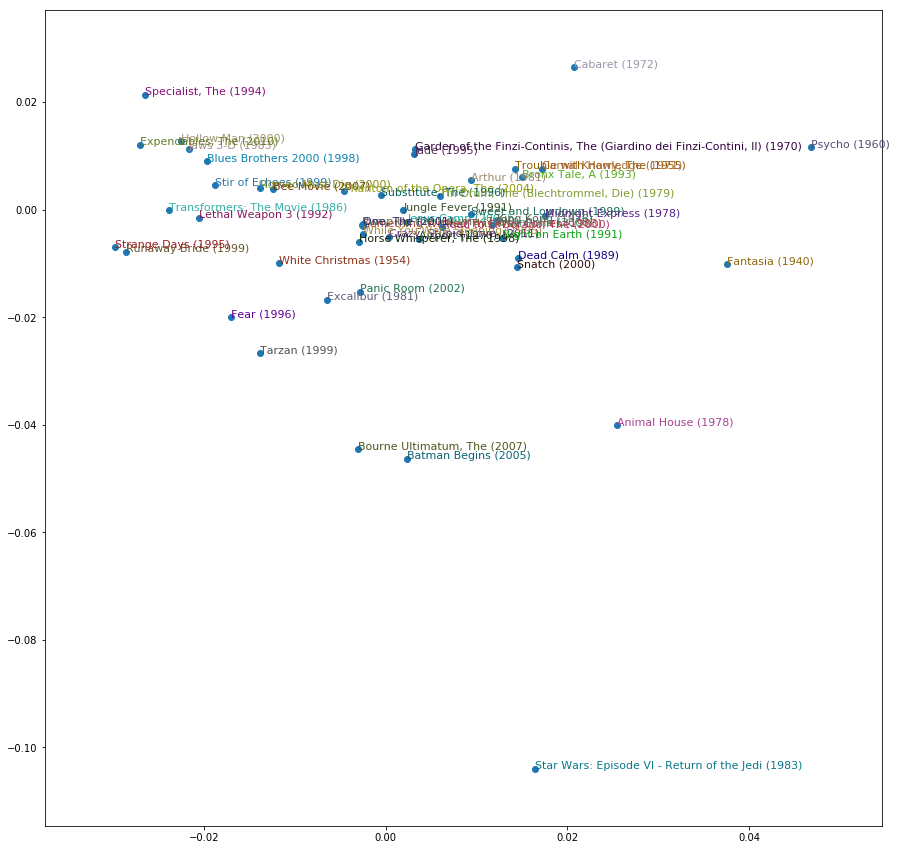

In [47]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example in Pytorch

In [50]:
??V

In [48]:
# Create a tensor in Pytorch with T
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(
  1  2
  3  4
 [torch.cuda.FloatTensor of size 2x2 (GPU 2)], 
   2   2
  10  10
 [torch.cuda.FloatTensor of size 2x2 (GPU 2)])

In [51]:
# Any time you have a math operator between tensors in numpy or pytorch, it will do element-wise, assuming they have the same
# shape. 
a*b


  2   4
 30  40
[torch.cuda.FloatTensor of size 2x2 (GPU 2)]

In [52]:
# sum along the 1st dim, so that's summing up the columns, in other word acrossing the row.
# This is like the per row inner product of 2 matrices
(a*b).sum(1)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 2)]

In [53]:
# Build our own custom neural net layer. More generically, we build the pytorch module. 
# Pytorch module is a very specific thing, you can use it as a layer in a NN, once you've created your pytorch module then you
# can throw it into a NN. 
# Also you need to implement a specific method called "forward"
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [54]:
# And a module works by assuming we've already got/instantiate one object called model here then treat that like a function, 
# then you can pass in something in () and it will calculate it.
# You have to create a Python class, this is a case that pytorch works well with Python.
model=DotProduct()

In [55]:
model(a,b)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 2)]

### Dot product model

In [56]:
# The 1st thing needs to be realized is that the userId and movieId may not be continues, for example they maybe start
# at 1M and go to 1M 1000. So if we use those IDs directly to look up into an embedding matrix, we would have to create
# an embedding matrix of size 1M 1000. The below lines of code are very handy in all kinds of machine learning.
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [57]:
print(n_users)
print(n_movies)

671
9066


In [58]:
ratings

,userId,movieId,rating,timestamp
0,0,0,2.5,1260759144
1,0,1,3.0,1260759179
2,0,2,3.0,1260759182
3,0,3,2.0,1260759185
4,0,4,4.0,1260759205
5,0,5,2.0,1260759151
6,0,6,2.0,1260759187
7,0,7,2.0,1260759148
8,0,8,3.5,1260759125
9,0,9,2.0,1260759131


In [59]:
class EmbeddingDot(nn.Module): # inherit from nn.Module
    def __init__(self, n_users, n_movies):
        super().__init__() # This you will got lots of cool stuffs from nn.Module by inheriting
        self.u = nn.Embedding(n_users, n_factors) # (#row, #column)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05) # According to Kaiming He init, 0.05~=sqrt(2/n_factor) is the std, 0 is the bias
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts): # cat->categorical, conts->continuous, leverage ColumnarModelData as rossman and it will pass the 2 variables
        users,movies = cats[:,0],cats[:,1] # Return a mini-batch
        u,m = self.u(users),self.m(movies) # Look up into the embedding matrices here like an array lookup, do it a whole mini batch at a time
        return (u*m).sum(1)

In [60]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [61]:
x

,userId,movieId
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
5,0,5
6,0,6
7,0,7
8,0,8
9,0,9


In [65]:
y

0         2.5
1         3.0
2         3.0
3         2.0
4         4.0
5         2.0
6         2.0
7         2.0
8         3.5
9         2.0
10        2.5
11        1.0
12        4.0
13        4.0
14        3.0
15        2.0
16        2.0
17        2.5
18        1.0
19        3.0
20        4.0
21        5.0
22        5.0
23        4.0
24        4.0
25        3.0
26        3.0
27        4.0
28        3.0
29        5.0
         ... 
99974     4.5
99975     5.0
99976     3.5
99977     4.0
99978     5.0
99979     5.0
99980     4.5
99981     4.5
99982     5.0
99983     4.0
99984     2.0
99985     2.0
99986     3.0
99987     4.0
99988     4.0
99989     4.5
99990     3.0
99991     4.0
99992     4.0
99993     3.5
99994     5.0
99995     4.0
99996     4.5
99997     4.0
99998     2.5
99999     2.5
100000    4.0
100001    4.0
100002    2.5
100003    3.5
Name: rating, Length: 100004, dtype: float32

In [68]:
type(x), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [26]:
# Thias is the only fastai thing we are using here.
# Grab a model data object from a data frame using that x and y
# cat_flds=['userId', 'movieId']
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [27]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda() # Instantiate the pytorch object
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9) # Create an optimizer. model.parameters() is inherit from nn.Module that will return all the weights need to update

In [28]:
# ??fit will give you the source code
# Notice that we are not using a learner, we are just using a pytorch module passed into fit function. So the fit here is still
# fastai thing but with lower level abstraction.
# This is suitable for the situation that you have a pytorch model, and you do not want to write your training loop, then you
# can call this fastai fit funciton. But you will not be able to use the SDGR and differential learning rates that's in the 
# learner, and that's the downside of going down to this level of abstraction.
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                                                                         
    0      1.733784   1.623152  
    1      1.059795   1.304467                                                                                         
    2      0.954743   1.228755                                                                                         



[1.2287548]

In [29]:
# We can manually do learning rate annealing/schedule
# set learning rate here in the opt
set_lrs(opt, 0.01)

In [30]:
# Then train again, and here we geta little bit better result
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                                                                         
    0      0.697004   1.144254  
    1      0.647608   1.132445                                                                                         
    2      0.659834   1.127299                                                                                         



[1.1272988]

### Bias

In [32]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [33]:
def get_emb(ni,nf): #ni->#input, nf->#factor
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [   # list comprehension
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1) # dot product as before
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze() # boardcasting: squeeze is pytorch function that adds an additional axis to support adding vector into matrix
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating # This is not necessary, but it really helps a lot
        return res

In [34]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda() # .cuda to put it on GPU, because we are not using leaner stuff but we have to manually say put it on GPU
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [35]:
# These numbers are doing good
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                                                                         
    0      0.829057   0.836052  
    1      0.804441   0.817727                                                                                         
    2      0.795685   0.808776                                                                                         



[0.80877602]

In [36]:
set_lrs(opt, 1e-2)

In [37]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                                                                         
    0      0.775581   0.802497  
    1      0.750676   0.801734                                                                                         
    2      0.735192   0.80094                                                                                          



[0.80094004]

### Mini net

In [38]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        #x = F.dropout(torch.cat([self.u(users),self.m(movies)], dim=1), 0.75)
        #x = F.dropout(F.relu(self.lin1(x)), 0.75)
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1)) #dim=1 means concatenate the columns together to create longer rows
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [39]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [40]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                                                                         
    0      0.897238   0.809426  
    1      0.813362   0.790658                                                                                         
    2      0.835892   0.788618                                                                                         



[0.78861797]

In [41]:
set_lrs(opt, 1e-3)

In [42]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                                                                         
    0      0.764942   0.787993  
    1      0.757806   0.793183                                                                                         
    2      0.761896   0.791168                                                                                         



[0.79116821]